In [1]:
# Shooth function: moving average of n values
import numpy as np
import matplotlib.pylab as plt

def smooth(a,WSZ):
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))




In [1]:
import pandas as pd
import matplotlib.pylab as plt
import math
import statistics
import numpy as np
import os


def segmentationUsingTwoMovingAverage(slowMovingAverage, fastMovingAverage, THRESHOLD, near):
    indexList = [0]*len(slowMovingAverage)
    curIndex = 0;

    for i in range(len(slowMovingAverage)):
        diff = slowMovingAverage[i] - fastMovingAverage[i]
        if diff > THRESHOLD:
            if curIndex == 0:
                indexList[curIndex] = i
                curIndex = curIndex + 1
                indexList[curIndex] = i
            else:
                if i <= indexList[curIndex] + near :
                    indexList[curIndex] = i
                else:
                    curIndex = curIndex + 1
                    indexList[curIndex] = i
                    curIndex = curIndex + 1
                    indexList[curIndex] = i

    intersectionIndex = [0] * (curIndex+1)
    output = []
    if curIndex > 0:
        for i in range(0, curIndex, 2):
            output.append([indexList[i], indexList[i + 1]])
            intersectionIndex[i] = indexList[i]
            
    return output, intersectionIndex

def calculateRoll(Ax, Ay, Az) :
    roll = []
    for i in range(len(Ax)):
        ax = Ax[i]
        ay = Ay[i]
        az = Az[i]
        rll = 180 * math.atan2(ax, math.sqrt(ay * ay + az * az)) / math.pi
        roll.append(rll)
    return roll

def calculatePitch(Ax, Ay, Az) :
    pitch = []
    for i in range(len(Ax)):
        ax = Ax[i]
        ay = Ay[i]
        az = Az[i]
        ptch = 180 * math.atan2(-ay, -az) / math.pi
        pitch.append(ptch)
    return pitch

def calculateYaw(Ax, Ay, Az) :
    yaw = []
    for i in range(len(Ax)):
        ax = Ax[i]
        ay = Ay[i]
        az = Az[i]
        yw = 180 * math.atan2(ay, ax) / math.pi
        yaw.append(yw)
    return yaw

def AutosenseWristFeatures(Ax, Ay, Az, Gx, Gy, Gz):
    fastSize = 31
    slowSize = 131

    gyr_mag = [1, 2, 4, 3, 5, 4, 7, 8, 7, 9, 2, 5, 50, 23, 34, 12, 43, 56, 65, 66]

    gyr_mag_800 = smooth(gyr_mag, fastSize)
    gyr_mag_8000 = smooth(gyr_mag, slowSize)
    
    gyr_intersections = segmentationUsingTwoMovingAverage(gyr_mag_800, gyr_mag_8000, 0, 4)
    
    roll = calculateRoll(Ax, Ay, Az)
    pitch = calculatePitch(Ax, Ay, Az)
    yaw = calculateYaw(Ax, Ay, Az)
    
def getData(cur_dir, filename):
    col_name = ['timestamp', 'value']
    D = pd.read_csv(cur_dir + filename, names = col_name)
    return D['timestamp'], D['value']

def getMag(x, y, z):
    mag = [0]*len(x)
    for i in range(len(x)):
        mag[i] = math.sqrt(x.iloc[i]*x.iloc[i] + y.iloc[i]*y.iloc[i]+z.iloc[i]*z.iloc[i])
        
    return mag

def filterDuration(gyr_intersections, t):
    gyr_intersections_filtered = []
    
    for I in gyr_intersections:
        dur = t[I[1]] - t[I[0]]
        
        if (dur >= 1000.0) & (dur <= 5000.0):
            gyr_intersections_filtered.append(I)
    return gyr_intersections_filtered

def filterRollPitch(gyr_intersections, roll, pitch):
    gyr_intersections_filtered = []
    
    for I in gyr_intersections:
        roll_sub = [roll[i] for i in range(len(roll)) if (i >= I[0]) & (i <= I[1])]
        pitch_sub = [pitch[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        
        mean_roll = statistics.mean(roll_sub)
        mean_pitch = statistics.mean(pitch_sub)
        
#         r > -20 && r <= 65 && p >= -125 && p <= -40
        if (mean_roll > -20) & (mean_roll <= 65) & (mean_pitch >= - 125) & (mean_pitch <= - 40):
            gyr_intersections_filtered.append(I)
    return gyr_intersections_filtered

def computeBasicFeatures(data):
    
    mean = np.mean(data)
    median = np.median(data)
    sd = np.std(data)
    quartile = np.percentile(data, 75) - np.percentile(data, 25)
    
    return mean, median, sd, quartile

def computeWindowFeatures(gyr_intersections, gyr_mag, roll, pitch, yaw, Ax, Ay, Az, t):
    all_features = []
    for I in gyr_intersections:
        roll_sub = [roll[i] for i in range(len(roll)) if (i >= I[0]) & (i <= I[1])]
        pitch_sub = [pitch[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        yaw_sub = [yaw[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        
        Ax_sub = [Ax[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        Ay_sub = [Ay[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        Az_sub = [Az[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        
        Gmag_sub = [gyr_mag[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        
        duration = t[I[1]] - t[I[0]]
        
        roll_mean, roll_median, roll_sd, roll_quartile = computeBasicFeatures(roll_sub)
        pitch_mean, pitch_median, pitch_sd, pitch_quartile = computeBasicFeatures(pitch_sub)
        yaw_mean, yaw_median, yaw_sd, yaw_quartile = computeBasicFeatures(yaw_sub)
        
        gyro_mean, gyro_median, gyro_sd, gyro_quartile = computeBasicFeatures(Gmag_sub)
        
        f = [t[I[0]], duration, roll_mean, roll_median, roll_sd, roll_quartile, pitch_mean, pitch_median, pitch_sd, pitch_quartile, yaw_mean, yaw_median, yaw_sd, yaw_quartile, gyro_mean, gyro_median, gyro_sd, gyro_quartile]
        all_features.append(f)
        
#     print(all_features)
    return all_features

def getLabel(st, et, epi_st, epi_et, puff_times):
    label = 0 # not puff
#     print(range(len(puff_times)))
    for i in range(len(puff_times)):
        if (puff_times[i] >= st) & (puff_times[i] <= et):
            label = 1
            return label
    
    for i in range(len(epi_et)):
        if ((epi_st[i] <=st) & (st <= epi_et[i])) | ((epi_st[i] <=et) & (et <= epi_et[i])):
            label = -1 # included episode but not puff
            return label
    
    return label

def getInputData(cur_dir, wrist):
    
    epi_st, epi_et = getData(cur_dir, 'episode_start_end.csv')
    
    if wrist == 0:
        puff_times = pd.read_csv(cur_dir + 'puff_timestamp_leftwrist.csv', names=['timings'])
        puff_times = puff_times['timings']
        puff_times = puff_times.values

        t, Ax = getData(cur_dir, 'left-wrist-accelx.csv')
        t, Ay = getData(cur_dir, 'left-wrist-accely.csv')
        t, Az = getData(cur_dir, 'left-wrist-accelz.csv')

        t, Gx = getData(cur_dir, 'left-wrist-gyrox.csv')
        t, Gy = getData(cur_dir, 'left-wrist-gyroy.csv')
        t, Gz = getData(cur_dir, 'left-wrist-gyroz.csv')
    else:
        puff_times = pd.read_csv(cur_dir + 'puff_timestamp_rightwrist.csv', names=['timings'])
        puff_times = puff_times['timings']
        puff_times = puff_times.values

        t, Ax = getData(cur_dir, 'right-wrist-accelx.csv')
        t, Ay = getData(cur_dir, 'right-wrist-accely.csv')
        t, Az = getData(cur_dir, 'right-wrist-accelz.csv')

        t, Gx = getData(cur_dir, 'right-wrist-gyrox.csv')
        t, Gy = getData(cur_dir, 'right-wrist-gyroy.csv')
        t, Gz = getData(cur_dir, 'right-wrist-gyroz.csv')
    
    return t, Ax, Ay, Az, Gx, Gy, Gz, epi_st, epi_et, puff_times
    
if __name__ == '__main__':
#     cur_dir = 'C:\\Users\\sakther\\Documents\\python_workshop\\md2k_mCerebralCortex\\wristdata\\'
#     cur_dir = 'C:\\Users\\sakther\\DATA\\csvdataSI_new\\p03\\s03\\'

    fastSize = 13
    slowSize = 131
    
    data_dir = 'C:\\Users\\sakther\\DATA\\csvdataSI_new\\'

    pids = ['p01', 'p02', 'p03', 'p04', 'p05', 'p06']
    pids = ['p04', 'p05', 'p06']
#     pids = ['p05']
    Xs = []
    Ys = []
    nSample = 0

    for i in range(len(pids)):
        basedir = data_dir + pids[i] + '\\'
        sids = [d for d in os.listdir(basedir) if os.path.isdir(os.path.join(basedir, d))]     

        for j in range(len(sids)):
            cur_dir = data_dir + pids[i] + '\\' + sids[j] + '\\'
            print(cur_dir)
            
            for wrist in range(2): # 0 for left wrist, 1 for right wrist
            
                t, Ax, Ay, Az, Gx, Gy, Gz, epi_st, epi_et, puff_times = getInputData(cur_dir, wrist)

                nSample = nSample + len(puff_times)

                A_mag = getMag(Ax, Ay, Az)
                gyr_mag = getMag(Gx, Gy, Gz)

                roll = calculateRoll(Ax, Ay, Az)
                pitch = calculatePitch(Ax, Ay, Az)
                yaw = calculateYaw(Ax, Ay, Az)

                gyr_mag_800 = smooth(gyr_mag, fastSize)
                gyr_mag_8000 = smooth(gyr_mag, slowSize)
                gyr_intersections, dont_care = segmentationUsingTwoMovingAverage(gyr_mag_8000, gyr_mag_800, 0, 4)
                gyr_intersections = filterDuration(gyr_intersections, t)
                gyr_intersections = filterRollPitch(gyr_intersections, roll, pitch)

                all_features = computeWindowFeatures(gyr_intersections, gyr_mag, roll, pitch, yaw, Ax, Ay, Az, t)

                st = [f[0] for f in all_features]
                et = [f[0]+f[1] for f in all_features]
                labels = [0]*len(st)

                for k in range(len(st)):
                    labels[k] = getLabel(st[k], et[k], epi_st, epi_et, puff_times)
                    if labels[k] != -1:
                        Xs.append(all_features[k][1:])
                        if labels[k] == 0:
                            Ys.append('non-puff')
                        else:
                            Ys.append('puff')

                print(len(Xs))
    #             print(sum(Ys))     
        
    print(len(Ys))
#     print(sum(Ys))
    print(nSample)
    
#     print(Xs)
#     print(Ys)

    Xs = np.array(Xs)
    Ys = np.array([Ys])
    M = np.concatenate((Xs, Ys.T), axis=1)

#     df = pd.DataFrame(M)
#     feature_name = ['duration', 'roll_mean', 'roll_median', 'roll_sd', 'roll_quartile', 'pitch_mean', 'pitch_median', 'pitch_sd', 'pitch_quartile', 'yaw_mean', 'yaw_median', 'yaw_sd', 'yaw_quartile', 'gyro_mean', 'gyro_median', 'gyro_sd', 'gyro_quartile', 'label(1:puff; 0:non-puff)']
#     df.to_csv("file_path.csv", header=feature_name)
    
    


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sakther\\DATA\\csvdataSI_new\\p04\\'

10534
155
86
14


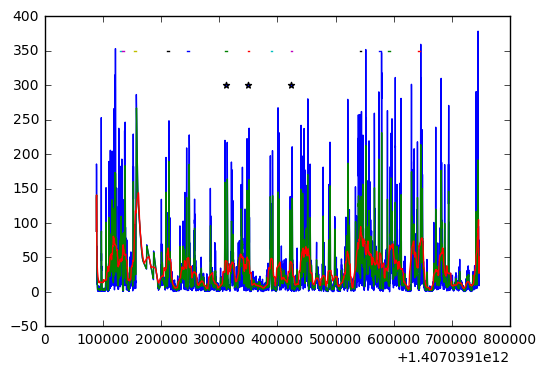

In [85]:

if __name__ == '__main__':
    
    cur_dir = 'C:\\Users\\sakther\\Documents\\python_workshop\\md2k_mCerebralCortex\\wristdata\\'
    
    gt = pd.read_csv(cur_dir + 'puffGroundtruth.csv')    
    
    epi_st, epi_et = getData(cur_dir, 'episode_start_end.csv')
    plt.scatter(gt, [300]*len(gt), marker="*")
    
    t, Ax = getData(cur_dir, 'right-wrist-accelx.csv')
    t, Ay = getData(cur_dir, 'right-wrist-accely.csv')
    t, Az = getData(cur_dir, 'right-wrist-accelz.csv')
    
    t, Gx = getData(cur_dir, 'right-wrist-gyrox.csv')
    t, Gy = getData(cur_dir, 'right-wrist-gyroy.csv')
    t, Gz = getData(cur_dir, 'right-wrist-gyroz.csv')    
    
    print(len(tt))
    
    A_mag = getMag(Ax, Ay, Az)
    gyr_mag = getMag(Gx, Gy, Gz)
    
    fastSize = 13
    slowSize = 131

    roll = calculateRoll(Ax, Ay, Az)
    pitch = calculatePitch(Ax, Ay, Az)
    yaw = calculateYaw(Ax, Ay, Az)

    gyr_mag_800 = smooth(gyr_mag, fastSize)
    gyr_mag_8000 = smooth(gyr_mag, slowSize)
    gyr_intersections, dont_care = segmentationUsingTwoMovingAverage(gyr_mag_8000, gyr_mag_800, 0, 4)
    print(len(gyr_intersections))
    gyr_intersections = filterDuration(gyr_intersections, t)
    print(len(gyr_intersections))
    gyr_intersections = filterRollPitch(gyr_intersections, roll, pitch)
    print(len(gyr_intersections))
    
#     for I in gyr_intersections:
#         print(I)
#         print(t[I[1]] - t[I[0]])

    tt = t # t[ (t>epi_st[0]) & (t< epi_et[0])]
    
    gyr_magt = gyr_mag #[gyr_mag[i] for i in range(len(t)) if (t[i]>epi_st[0]) & (t[i]< epi_et[0])]
    gyr_mag800t =gyr_mag_800 # [gyr_mag_800[i] for i in range(len(t)) if (t[i]>epi_st[0]) & (t[i]< epi_et[0])]
    gyr_mag8000t =gyr_mag_8000 #[gyr_mag_8000[i] for i in range(len(t)) if (t[i]>epi_st[0]) & (t[i]< epi_et[0])]
    
    gyr_intersectionst = gyr_intersections # [gyr_intersections[i] for i in range(len(gyr_intersections)) if (gyr_intersections[i][0]>epi_st[0]) & (gyr_intersections[i][0]< epi_et[0])]
    plt.plot(tt, gyr_magt,  label='gyro_mag')
    plt.plot(tt, gyr_mag800t,  label='gyro_mag_800')
    plt.plot(tt, gyr_mag8000t,  label='gyro_mag_8000')

    for I in gyr_intersectionst:
        x1 = t[I[0]]
        x2 = t[I[1]]
        
        plt.plot([x1, x2], [350, 350])

        

    
#     plt.legend()
    plt.show()

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import math
import statistics
import numpy as np
import os

def complementary_filter(ts, acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z, fq=16):

    dt = 1.0/fq  #1/16.0; 
    M_PI =  math.pi;
    hpf = 0.85;
    lpf = 0.15;

    thetaX_acc = [0]*len(acc_x) # math.atan2(-acc_z,acc_y)*180/M_PI;
    thetaY_acc = [0]*len(acc_x) # math.atan2(acc_x,acc_z)*180/M_PI;
    thetaZ_acc = [0]*len(acc_x) # math.atan2(acc_y,acc_x)*180/M_PI;

    thetaX = [0]*len(gyr_x)
    thetaY = [0]*len(gyr_y)
    thetaZ = [0]*len(gyr_z)

    for a in range(len(gyr_x)):
        thetaX_acc[a] = math.atan2(-acc_z[a],acc_y[a])*180/M_PI
        thetaY_acc[a] = math.atan2(acc_x[a],acc_z[a])*180/M_PI
        thetaZ_acc[a] = math.atan2(acc_y[a],acc_x[a])*180/M_PI
        
        if a == 0:
            thetaX[a] = hpf*thetaX[a]*dt + lpf*thetaX_acc[a]
            thetaY[a] = hpf*thetaY[a]*dt + lpf*thetaY_acc[a]
            thetaZ[a] = hpf*thetaZ[a]*dt + lpf*thetaZ_acc[a]
        else:
            thetaX[a] = hpf*(thetaX[a-1] + gyr_x[a]*dt) + lpf*thetaX_acc[a]
            thetaY[a] = hpf*(thetaY[a-1] + gyr_y[a]*dt) + lpf*thetaY_acc[a]
            thetaZ[a] = hpf*(thetaZ[a-1] + gyr_z[a]*dt) + lpf*thetaZ_acc[a]
        end
    end

    
   

p01
C:\Users\sakther\DATA\csvdataSI_new\p01\s02\
C:\Users\sakther\DATA\csvdataSI_new\p01\s03\
C:\Users\sakther\DATA\csvdataSI_new\p01\s04\
C:\Users\sakther\DATA\csvdataSI_new\p01\s05\
p02
C:\Users\sakther\DATA\csvdataSI_new\p02\s03\
C:\Users\sakther\DATA\csvdataSI_new\p02\s04\
C:\Users\sakther\DATA\csvdataSI_new\p02\s05\
C:\Users\sakther\DATA\csvdataSI_new\p02\s06\
C:\Users\sakther\DATA\csvdataSI_new\p02\s07\
p03
C:\Users\sakther\DATA\csvdataSI_new\p03\s01\
C:\Users\sakther\DATA\csvdataSI_new\p03\s02\
p04
C:\Users\sakther\DATA\csvdataSI_new\p04\s01\
p05
C:\Users\sakther\DATA\csvdataSI_new\p05\s01\
C:\Users\sakther\DATA\csvdataSI_new\p05\wristdata\
p06
C:\Users\sakther\DATA\csvdataSI_new\p06\s01\


C:\Users\sakther\DATA\csvdataSI_new\p04\s01\
24
67
C:\Users\sakther\DATA\csvdataSI_new\p05\s01\
103
150
C:\Users\sakther\DATA\csvdataSI_new\p06\s01\
494
888
888
40


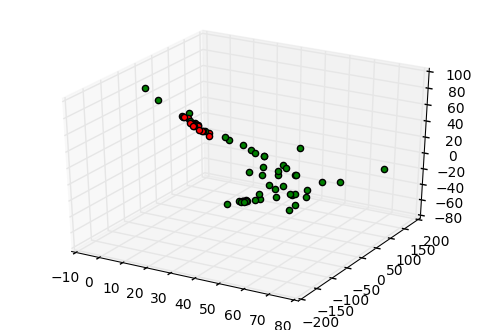

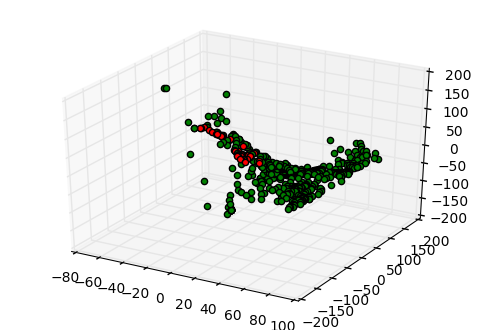

In [18]:
# plot roll pitch

import pandas as pd
import matplotlib.pylab as plt
import math
import statistics
import numpy as np
import os

def computeWindowFeatures_new(gyr_intersections, gyr_mag, roll, pitch, yaw, Ax, Ay, Az, t):
    A_mag = getMag(Ax, Ay, Az)
    all_features = []
    for I in gyr_intersections:
        roll_sub = [roll[i] for i in range(len(roll)) if (i >= I[0]) & (i <= I[1]) & (A_mag[i] >0.9) & (A_mag[i] < 1.1) ]
        pitch_sub = [pitch[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1]) & (A_mag[i] >0.9) & (A_mag[i] < 1.1) ]
        yaw_sub = [yaw[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1]) & (A_mag[i] >0.9) & (A_mag[i] < 1.1) ]
        
        Ax_sub = [Ax[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        Ay_sub = [Ay[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        Az_sub = [Az[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        
        Gmag_sub = [gyr_mag[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        
        duration = t[I[1]] - t[I[0]]
        
        if (roll_sub == None) | (len(roll_sub) == 0):
            continue
        
        roll_mean, roll_median, roll_sd, roll_quartile = computeBasicFeatures(roll_sub)
        pitch_mean, pitch_median, pitch_sd, pitch_quartile = computeBasicFeatures(pitch_sub)
        yaw_mean, yaw_median, yaw_sd, yaw_quartile = computeBasicFeatures(yaw_sub)
        
        gyro_mean, gyro_median, gyro_sd, gyro_quartile = computeBasicFeatures(Gmag_sub)
        
        f = [t[I[0]], duration, roll_mean, roll_median, roll_sd, roll_quartile, pitch_mean, pitch_median, pitch_sd, pitch_quartile, yaw_mean, yaw_median, yaw_sd, yaw_quartile, gyro_mean, gyro_median, gyro_sd, gyro_quartile]
        all_features.append(f)
        
#     print(all_features)
    return all_features

from mpl_toolkits.mplot3d import Axes3D

    
if __name__ == '__main__':
#     cur_dir = 'C:\\Users\\sakther\\Documents\\python_workshop\\md2k_mCerebralCortex\\wristdata\\'
#     cur_dir = 'C:\\Users\\sakther\\DATA\\csvdataSI_new\\p03\\s03\\'

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fastSize = 13
    slowSize = 131
    
    data_dir = 'C:\\Users\\sakther\\DATA\\csvdataSI_new\\'

    pids = ['p01', 'p02', 'p03', 'p04', 'p05', 'p06']
    pids = ['p04', 'p05', 'p06']
    Xs = []
    Ys = []
    nSample = 0

    for i in range(len(pids)):
        basedir = data_dir + pids[i] + '\\'
        sids = [d for d in os.listdir(basedir) if os.path.isdir(os.path.join(basedir, d))]     

        for j in range(len(sids)):
            cur_dir = data_dir + pids[i] + '\\' + sids[j] + '\\'
            print(cur_dir)
            
            for wrist in range(2): # 0 for left wrist, 1 for right wrist
            
                t, Ax, Ay, Az, Gx, Gy, Gz, epi_st, epi_et, puff_times = getInputData(cur_dir, wrist)

                nSample = nSample + len(puff_times)

                A_mag = getMag(Ax, Ay, Az)
                gyr_mag = getMag(Gx, Gy, Gz)

                roll = calculateRoll(Ax, Ay, Az)
                pitch = calculatePitch(Ax, Ay, Az)
                yaw = calculateYaw(Ax, Ay, Az)

                gyr_mag_800 = smooth(gyr_mag, fastSize)
                gyr_mag_8000 = smooth(gyr_mag, slowSize)
                gyr_intersections, dont_care = segmentationUsingTwoMovingAverage(gyr_mag_8000, gyr_mag_800, 0, 4)
                gyr_intersections = filterDuration(gyr_intersections, t)
#                 gyr_intersections = filterRollPitch(gyr_intersections, roll, pitch)

                all_features = computeWindowFeatures_new(gyr_intersections, gyr_mag, roll, pitch, yaw, Ax, Ay, Az, t)

                st = [f[0] for f in all_features]
                et = [f[0]+f[1] for f in all_features]
                labels = [0]*len(st)

                for k in range(len(st)):
                    labels[k] = getLabel(st[k], et[k], epi_st, epi_et, puff_times)
                    if labels[k] != -1:
                        Xs.append(all_features[k][1:])
                        if labels[k] == 0:
                            Ys.append('non-puff')
                            ax.scatter(all_features[k][2], all_features[k][6], all_features[k][10], c="g")
                        else:
                            Ys.append('puff')
                            ax.scatter(all_features[k][2], all_features[k][6], all_features[k][10], c="r")

                print(len(Xs))
    #             print(sum(Ys))     
        
    print(len(Ys))
#     print(sum(Ys))
    print(nSample)
    plt.show()
#     print(Xs)
#     print(Ys)

#     Xs = np.array(Xs)
#     Ys = np.array([Ys])
#     M = np.concatenate((Xs, Ys.T), axis=1)

#     df = pd.DataFrame(M)
#     feature_name = ['duration', 'roll_mean', 'roll_median', 'roll_sd', 'roll_quartile', 'pitch_mean', 'pitch_median', 'pitch_sd', 'pitch_quartile', 'yaw_mean', 'yaw_median', 'yaw_sd', 'yaw_quartile', 'gyro_mean', 'gyro_median', 'gyro_sd', 'gyro_quartile', 'label(1:puff; 0:non-puff)']
#     df.to_csv("file_path.csv", header=feature_name)
    
    


C:\Users\sakther\DATA\csvdataSI_new\p04\s01\
24
67
C:\Users\sakther\DATA\csvdataSI_new\p05\s01\
104
151
C:\Users\sakther\DATA\csvdataSI_new\p06\s01\
497
919
919
40


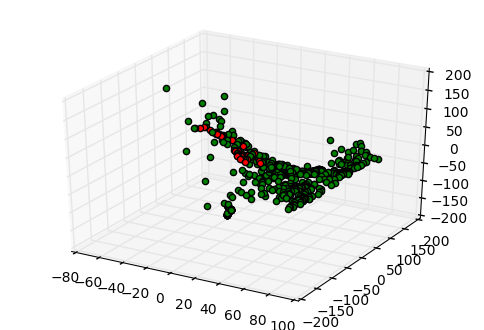

In [19]:
# plot roll pitch

import pandas as pd
import matplotlib.pylab as plt
import math
import statistics
import numpy as np
import os

def computeWindowFeatures_new(gyr_intersections, gyr_mag, roll, pitch, yaw, Ax, Ay, Az, t):
    A_mag = getMag(Ax, Ay, Az)
    all_features = []
    for I in gyr_intersections:
        roll_sub = [roll[i] for i in range(len(roll)) if (i >= I[0]) & (i <= I[1]) & (A_mag[i] >0.9) & (A_mag[i] < 1.1) ]
        pitch_sub = [pitch[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1]) & (A_mag[i] >0.9) & (A_mag[i] < 1.1) ]
        yaw_sub = [yaw[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1]) & (A_mag[i] >0.9) & (A_mag[i] < 1.1) ]
        
        Ax_sub = [Ax[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        Ay_sub = [Ay[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        Az_sub = [Az[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        
        Gmag_sub = [gyr_mag[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        
        duration = t[I[1]] - t[I[0]]
        
        if (roll_sub == None) | (len(roll_sub) == 0):
            continue
        
        roll_mean, roll_median, roll_sd, roll_quartile = computeBasicFeatures(roll_sub)
        pitch_mean, pitch_median, pitch_sd, pitch_quartile = computeBasicFeatures(pitch_sub)
        yaw_mean, yaw_median, yaw_sd, yaw_quartile = computeBasicFeatures(yaw_sub)
        
        gyro_mean, gyro_median, gyro_sd, gyro_quartile = computeBasicFeatures(Gmag_sub)
        
        f = [t[I[0]], duration, roll_mean, roll_median, roll_sd, roll_quartile, pitch_mean, pitch_median, pitch_sd, pitch_quartile, yaw_mean, yaw_median, yaw_sd, yaw_quartile, gyro_mean, gyro_median, gyro_sd, gyro_quartile]
        all_features.append(f)
        
#     print(all_features)
    return all_features

from mpl_toolkits.mplot3d import Axes3D

    
if __name__ == '__main__':
#     cur_dir = 'C:\\Users\\sakther\\Documents\\python_workshop\\md2k_mCerebralCortex\\wristdata\\'
#     cur_dir = 'C:\\Users\\sakther\\DATA\\csvdataSI_new\\p03\\s03\\'

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fastSize = 13
    slowSize = 131
    
    data_dir = 'C:\\Users\\sakther\\DATA\\csvdataSI_new\\'

    pids = ['p01', 'p02', 'p03', 'p04', 'p05', 'p06']
    pids = ['p04', 'p05', 'p06']
    Xs = []
    Ys = []
    nSample = 0

    for i in range(len(pids)):
        basedir = data_dir + pids[i] + '\\'
        sids = [d for d in os.listdir(basedir) if os.path.isdir(os.path.join(basedir, d))]     

        for j in range(len(sids)):
            cur_dir = data_dir + pids[i] + '\\' + sids[j] + '\\'
            print(cur_dir)
            
            for wrist in range(2): # 0 for left wrist, 1 for right wrist
            
                t, Ax, Ay, Az, Gx, Gy, Gz, epi_st, epi_et, puff_times = getInputData(cur_dir, wrist)

                nSample = nSample + len(puff_times)

                A_mag = getMag(Ax, Ay, Az)
                gyr_mag = getMag(Gx, Gy, Gz)

                roll = calculateRoll(Ax, Ay, Az)
                pitch = calculatePitch(Ax, Ay, Az)
                yaw = calculateYaw(Ax, Ay, Az)

                gyr_mag_800 = smooth(gyr_mag, fastSize)
                gyr_mag_8000 = smooth(gyr_mag, slowSize)
                gyr_intersections, dont_care = segmentationUsingTwoMovingAverage(gyr_mag_8000, gyr_mag_800, 0, 4)
                gyr_intersections = filterDuration(gyr_intersections, t)
#                 gyr_intersections = filterRollPitch(gyr_intersections, roll, pitch)

                all_features = computeWindowFeatures(gyr_intersections, gyr_mag, roll, pitch, yaw, Ax, Ay, Az, t)

                st = [f[0] for f in all_features]
                et = [f[0]+f[1] for f in all_features]
                labels = [0]*len(st)

                for k in range(len(st)):
                    labels[k] = getLabel(st[k], et[k], epi_st, epi_et, puff_times)
                    if labels[k] != -1:
                        Xs.append(all_features[k][1:])
                        if labels[k] == 0:
                            Ys.append('non-puff')
                            ax.scatter(all_features[k][2], all_features[k][6], all_features[k][10], c="g")
                        else:
                            Ys.append('puff')
                            ax.scatter(all_features[k][2], all_features[k][6], all_features[k][10], c="r")

                print(len(Xs))
    #             print(sum(Ys))     
        
    print(len(Ys))
#     print(sum(Ys))
    print(nSample)
    plt.show()
#     print(Xs)
#     print(Ys)

#     Xs = np.array(Xs)
#     Ys = np.array([Ys])
#     M = np.concatenate((Xs, Ys.T), axis=1)

#     df = pd.DataFrame(M)
#     feature_name = ['duration', 'roll_mean', 'roll_median', 'roll_sd', 'roll_quartile', 'pitch_mean', 'pitch_median', 'pitch_sd', 'pitch_quartile', 'yaw_mean', 'yaw_median', 'yaw_sd', 'yaw_quartile', 'gyro_mean', 'gyro_median', 'gyro_sd', 'gyro_quartile', 'label(1:puff; 0:non-puff)']
#     df.to_csv("file_path.csv", header=feature_name)
    
    


In [ ]:
# plot roll pitch

import pandas as pd
import matplotlib.pylab as plt
import math
import statistics
import numpy as np
import os

def computeWindowFeatures_new(gyr_intersections, gyr_mag, roll, pitch, yaw, Ax, Ay, Az, t):
    A_mag = getMag(Ax, Ay, Az)
    all_features = []
    for I in gyr_intersections:
        roll_sub = [roll[i] for i in range(len(roll)) if (i >= I[0]) & (i <= I[1]) & (A_mag[i] >0.9) & (A_mag[i] < 1.1) ]
        pitch_sub = [pitch[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1]) & (A_mag[i] >0.9) & (A_mag[i] < 1.1) ]
        yaw_sub = [yaw[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1]) & (A_mag[i] >0.9) & (A_mag[i] < 1.1) ]
        
        Ax_sub = [Ax[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        Ay_sub = [Ay[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        Az_sub = [Az[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        
        Gmag_sub = [gyr_mag[i] for i in range(len(pitch)) if (i >= I[0]) & (i <= I[1])]
        
        duration = t[I[1]] - t[I[0]]
        
        if (roll_sub == None) | (len(roll_sub) == 0):
            continue
        
        roll_mean, roll_median, roll_sd, roll_quartile = computeBasicFeatures(roll_sub)
        pitch_mean, pitch_median, pitch_sd, pitch_quartile = computeBasicFeatures(pitch_sub)
        yaw_mean, yaw_median, yaw_sd, yaw_quartile = computeBasicFeatures(yaw_sub)
        
        gyro_mean, gyro_median, gyro_sd, gyro_quartile = computeBasicFeatures(Gmag_sub)
        
        f = [t[I[0]], duration, roll_mean, roll_median, roll_sd, roll_quartile, pitch_mean, pitch_median, pitch_sd, pitch_quartile, yaw_mean, yaw_median, yaw_sd, yaw_quartile, gyro_mean, gyro_median, gyro_sd, gyro_quartile]
        all_features.append(f)
        
#     print(all_features)
    return all_features

from mpl_toolkits.mplot3d import Axes3D

    
if __name__ == '__main__':
#     cur_dir = 'C:\\Users\\sakther\\Documents\\python_workshop\\md2k_mCerebralCortex\\wristdata\\'
#     cur_dir = 'C:\\Users\\sakther\\DATA\\csvdataSI_new\\p03\\s03\\'

    fastSize = 13
    slowSize = 131
    
    data_dir = 'C:\\Users\\sakther\\DATA\\csvdataSI_new\\'

    pids = ['p01', 'p02', 'p03', 'p04', 'p05', 'p06']
    pids = ['p04', 'p05', 'p06']
    Xs = []
    Ys = []
    nSample = 0
    
    pRoll =[]
    pPitch =[]
    pYaw =[]
    nRoll =[]
    nPitch =[]
    nYaw =[]
    
    for i in range(len(pids)):
        basedir = data_dir + pids[i] + '\\'
        sids = [d for d in os.listdir(basedir) if os.path.isdir(os.path.join(basedir, d))]     

        for j in range(len(sids)):
            cur_dir = data_dir + pids[i] + '\\' + sids[j] + '\\'
            print(cur_dir)
            
            for wrist in range(2): # 0 for left wrist, 1 for right wrist
            
                t, Ax, Ay, Az, Gx, Gy, Gz, epi_st, epi_et, puff_times = getInputData(cur_dir, wrist)

                nSample = nSample + len(puff_times)

                A_mag = getMag(Ax, Ay, Az)
                gyr_mag = getMag(Gx, Gy, Gz)

                roll = calculateRoll(Ax, Ay, Az)
                pitch = calculatePitch(Ax, Ay, Az)
                yaw = calculateYaw(Ax, Ay, Az)

                gyr_mag_800 = smooth(gyr_mag, fastSize)
                gyr_mag_8000 = smooth(gyr_mag, slowSize)
                gyr_intersections, dont_care = segmentationUsingTwoMovingAverage(gyr_mag_8000, gyr_mag_800, 0, 4)
                gyr_intersections = filterDuration(gyr_intersections, t)
#                 gyr_intersections = filterRollPitch(gyr_intersections, roll, pitch)

                all_features = computeWindowFeatures(gyr_intersections, gyr_mag, roll, pitch, yaw, Ax, Ay, Az, t)

                st = [f[0] for f in all_features]
                et = [f[0]+f[1] for f in all_features]
                labels = [0]*len(st)

                for k in range(len(st)):
                    labels[k] = getLabel(st[k], et[k], epi_st, epi_et, puff_times)
                    if labels[k] != -1:
                        Xs.append(all_features[k][1:])
                        if labels[k] == 0:
                            Ys.append('non-puff')
                            nRoll.append(all_features[k][2])
                            nPitch.append(all_features[k][6])
                            nYaw.append(all_features[k][10])
                        else:
                            Ys.append('puff')
                            pRoll.append(all_features[k][2])
                            pPitch.append(all_features[k][6])
                            pYaw.append(all_features[k][10])

                print(len(Xs))
    #             print(sum(Ys))     
        
    print(len(Ys))
#     print(sum(Ys))
    print(nSample)
    plt.show()
#     print(Xs)
#     print(Ys)

#     Xs = np.array(Xs)
#     Ys = np.array([Ys])
#     M = np.concatenate((Xs, Ys.T), axis=1)

#     df = pd.DataFrame(M)
#     feature_name = ['duration', 'roll_mean', 'roll_median', 'roll_sd', 'roll_quartile', 'pitch_mean', 'pitch_median', 'pitch_sd', 'pitch_quartile', 'yaw_mean', 'yaw_median', 'yaw_sd', 'yaw_quartile', 'gyro_mean', 'gyro_median', 'gyro_sd', 'gyro_quartile', 'label(1:puff; 0:non-puff)']
#     df.to_csv("file_path.csv", header=feature_name)
    
    
